[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fvalerii/geospatial-land-classification/blob/main/notebooks/01_data_handling/02_keras_data_augmentation.ipynb)


# 🛰️ 02: Scalable Augmentation Strategies & High-Throughput Pipelines
### Geospatial Land Classification Study (TensorFlow/Keras Phase)
(*This is the 2nd module in a 9-part series exploring geospatial hybrid models.*)

### 🧪 Methodology & Technical Objectives
This research module focuses on the optimization of the data ingestion layer using the **TensorFlow Data (`tf.data`) API**. We evaluate the transition from manual Pythonic generators to vectorized, hardware-accelerated pipelines capable of sustaining GPU saturation during training.

**Key Technical Focus:**
* **Vectorized Augmentation:** Implementing on-the-fly spatial transformations (Rotations, Flips, Zooms) to mitigate overfitting.
* **Pipeline Optimization:** Leveraging `.cache()`, `.prefetch()`, and `.map()` for asynchronous data preparation.
* **API Benchmarking:** Comparing custom `DataGenerator` implementations against the native `image_dataset_from_directory` utility.

## Introduction

This module evaluates two primary **Keras** methodologies for the construction of automated data pipelines: custom Pythonic generators and optimized native utilities

### Implementation: Deterministic Pythonic Generators
A Python generator function to load, preprocess, and yield batches of data on-the-fly that simultes the working of a production-level data generator.

### Optimization: Vectorized Ingestion via tf.data API
The highly optimized `tf.keras.utils.image_dataset_from_directory` function, which is the standard, production-ready approach for most image classification tasks.

Finally, we compare these two methods to understand their trade-offs in terms of simplicity, features, and performance.

## Table of contents

<font size = 3> 
    
1. [Import libraries and packages](#Import-libraries-and-packages)
2. [Technical Foundation: Pythonic Generators](#Technical-Foundation:-Pythonic-Generators)
3. [High-Throughput Pipelines: tf.data API](#High-Throughput-Pipelines:-tf.data-API)
4. [Comparison and analysis](#Comparison-and-analysis)

</font>
    
</div>


## Import libraries and packages

In [1]:
import os, sys

# --- Universal Environment Setup ---
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Use the fast local runtime disk for satellite imagery
    BASE_DIR = '/content/'
    os.chdir(BASE_DIR)
    
    # Install specific versions for vit-research environment stability
    !pip install numpy==1.26.0 tensorflow==2.19.0 requests --quiet
    
    print(f"✅ Environment: Google Colab. In-memory data loading will use: {BASE_DIR}")
else:
    # Local System (relative to the notebook folder)
    BASE_DIR = './' 
    print(f"✅ Environment: Local System. Directory: {os.getcwd()}")

✅ Environment: Local System. Directory: c:\Users\Fabrizio\Documents\GitHub\notebooks\01_data_handling


In [2]:
import requests, tarfile
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

## Dataset acquisition and extraction
The dataset is fetched directly from the public IBM Cloud Object Storage. To ensure local reproducibility and bypass proprietary library dependencies, a standard Python pipeline using `requests` and `tarfile` is implemented for automated artifact retrieval and decompression.


In [3]:
# --- Data Ingestion Configuration ---
# Matches your existing path logic: base_dir = os.path.join(extract_dir, 'images_dataSAT')
DATA_URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/5vTzHBmQUaRNJQe5szCyKw/images-dataSAT.tar"
TAR_FILE = os.path.join(BASE_DIR, "images-dataSAT.tar")
EXTRACT_PATH = BASE_DIR

def download_and_extract(url, destination, extract_to):
    """
    Handles automated retrieval and decompression. 
    Optimized to land data directly into the project root.
    """
    # 1. Streamed Download
    if not os.path.exists(destination):
        print(f"🛰️ Downloading archive to: {destination}")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        
        with open(destination, "wb") as f, tqdm(
            desc="Downloading Dataset",
            total=total_size,
            unit='iB', unit_scale=True, unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = f.write(data)
                bar.update(size)
    else:
        print(f"✅ Archive already exists.")

    # 2. Extraction 
    expected_folder = os.path.join(extract_to, 'images_dataSAT')
    if not os.path.exists(expected_folder):
        print(f"📦 Extracting dataset to: {extract_to}")
        with tarfile.open(destination, "r") as tar:
            tar.extractall(path=extract_to)
        print("🚀 Extraction complete.")
    else:
        print(f"✅ Dataset folder '{expected_folder}' already verified.")

# Run the ingestion
download_and_extract(DATA_URL, TAR_FILE, EXTRACT_PATH)

✅ Archive already exists.
✅ Dataset folder './images_dataSAT' already verified.


### 📂 Directory Hierarchy and Class Mapping. The dataset follows a standard categorical sub-directory structure, enabling automated class inference for agricultural and non-agricultural classification.

```python
images_dataSAT/
├── class_0_non_agri/
└── class_1_agri/

```

**class_0_non_agri** is the non-agricultural land class, as defined earlier, and it represents images with non-cultivable land. 

**class_1_agri**, on the other hand, is the agricultural land class, and it represents the images with cultivable land.

In [4]:
# Define directories
base_dir = os.path.join(EXTRACT_PATH, 'images_dataSAT')
# Note: It's common practice for class directories to have clear names.
# Using 'class_0' and 'class_1' is good for automatic inference.
dir_non_agri = os.path.join(base_dir, 'class_0_non_agri')
dir_agri = os.path.join(base_dir, 'class_1_agri')

### **Paths list and labels:** 
We created "**all_image_paths**" list containing paths of all files for both folders, *class_0_non_agri* and *class_1_agri*, in the base directory.
the label definition consisted of assigning label "0" to non_agri images, and label "1" for each image in the agri folder.

In [5]:
# Initialize empty lists
all_image_paths = []
all_labels = []

# Define labels
label_non_agri = 0
label_agri = 1

# Loops to fill the lists
for file_name in os.listdir(dir_non_agri):
    all_image_paths.append(os.path.join(dir_non_agri, file_name))
    all_labels.append(label_non_agri)

for file_name in os.listdir(dir_agri):
    all_image_paths.append(os.path.join(dir_agri, file_name))
    all_labels.append(label_agri)


### Create a temporary list "**temp**" by binding the image paths and labels using the `zip` function. 
Then, randomly select and print 5 image paths and their corresponding labels.


In [6]:
# Create temporary list
temp = list(zip(all_image_paths, all_labels))
# Select 5 random indeces from an array the size of temp
indices = np.random.choice(len(temp), 5, replace=False)
rand_imgs = [temp[i] for i in indices]
# Print the 5 random paths and corresponding labels 
print('5 randomly selected paths and labels:\n')
for item in rand_imgs:
    print(item)


5 randomly selected paths and labels:

('./images_dataSAT\\class_1_agri\\tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_6437.jpg', 1)
('./images_dataSAT\\class_0_non_agri\\tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_20195.jpg', 0)
('./images_dataSAT\\class_0_non_agri\\tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_8445.jpg', 0)
('./images_dataSAT\\class_0_non_agri\\tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_23573.jpg', 0)
('./images_dataSAT\\class_0_non_agri\\tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_23496.jpg', 0)


## Technical Foundation: Pythonic Generators

A custom data generator function uses the `yield` keyword. Unlike a regular function that returns once and terminates, a generator can yield multiple values, pausing its state between each call. This "lazy evaluation" is the core principle behind memory-efficient sequential loading. For deep learning, this means we can create a generator that provides one batch of data, waits for the model to train on it, and then resumes to provide the next batch, all without loading the entire dataset into RAM.


### Create the generator function

The `custom_data_generator` function builds an infinite Python generator that supplies mini-batches of images and labels to a Keras model during training. It accepts four arguments: `image_paths`, a list of file locations; `labels`, the corresponding class IDs; `batch_size`, the number of samples per update; and `target_size`, a tuple dictating each image’s resize dimensions. 

At the start of every epoch, in the code we create an index array equal to the dataset length, **shuffle it with NumPy**, and reorder both paths and labels identically, preserving their pairing while randomizing order. The outer `while True` loop keeps the generator alive for successive epochs. Inside, a `for` loop walks through the shuffled dataset in `batch_size` steps, slicing out `batch_paths` and `batch_labels`. For each path, `tf.keras.utils.load_img` reads the image and rescales it to `target_size`; `img_to_array` converts the PIL image to a float32 NumPy array. These arrays accumulate in `batch_images`. 

After the inner loop finishes, the batch is transformed into a NumPy array and divided by 255.0, scaling pixel values from 0–255 to 0–1, which speeds convergence and stabilizes gradients. Finally, the generator yields a tuple (`batch_images`, `batch_labels`). It supports easy augmentation and custom preprocessing.



In [7]:
def custom_data_generator(image_paths, labels, batch_size, target_size=(64, 64)):
    """A custom data generator to feed a Keras model.
    A generator is a Python function that yields batches of data indefinitely,
    which is useful for training models on large datasets that cannot fit into memory.
    Args:
        image_paths (list): List of file paths to images.
        labels (list): Corresponding labels for the images.
        batch_size (int): Number of samples per batch.
        target_size (tuple): Desired image size (height, width) for resizing.
    Yields:
        Tuple of (batch_images, batch_labels) where:
        - batch_images: A numpy array of shape (batch_size, target_size[0],
          target_size[1], 3) containing the preprocessed image data.
        - batch_labels: A numpy array of shape (batch_size,) containing the
          corresponding labels for the batch images.
    """
    num_samples = len(image_paths)
    while True: 
        # Shuffle data at the beginning of each epoch
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        shuffled_paths = np.array(image_paths)[indices]
        shuffled_labels = np.array(labels)[indices]
        
        # Generate batch data
        for offset in range(0, num_samples, batch_size):
            batch_paths = shuffled_paths[offset:offset+batch_size]
            batch_labels = shuffled_labels[offset:offset+batch_size]
            
            # Load and preprocess images from the batch
            batch_images = []
            for path in batch_paths:
                img = tf.keras.utils.load_img(path, target_size=target_size)
                img_array = tf.keras.utils.img_to_array(img)
                batch_images.append(img_array)
            
            # Normalize and yield the batch data
            yield np.array(batch_images) / 255.0, np.array(batch_labels)

### Test and visualize the custom generator
Before feeding a generator to a model, it is essential to test it. 
First we instantiate `custom_data_generator` using `image_paths`, `labels` and `batch_size`, defining the key dataloading hyperparameters.

Next we use `next(my_generator)`to get a batch of data. By calling `next(my_generator)`, the generator executes its code until it hits the `yield` statement and to return the yielded values. This allows to inspect a single batch to verify its shape, data types, and content. Visualizing the images with their corresponding labels, using tools like `matplotlib.pyplot.imshow`, provides a sanity check to ensure that the loading, preprocessing, and labeling logic is correct.

We obtain a batch of data, using batch size 8 and the `custom_data_generator` function. 
We print the batch shape for the image and label the data obtained and display the images and corresponding labels using `matplotlib.pyplot` library for visual inspection.


Images batch shape: (8, 64, 64, 3)
Labels shape: (8,)


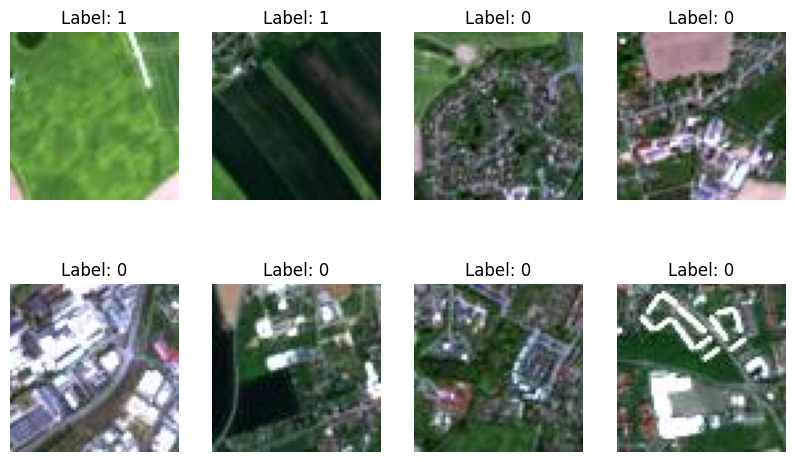

In [8]:
# Instantiate data generator
batch_size=8
data_generator = custom_data_generator(image_paths=all_image_paths,
                                       labels=all_labels,
                                       batch_size=batch_size)
# Get one batch
images, labels = next(data_generator)

# Print shapes of batch items
print(f'Images batch shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

# Display images and labels in the batch
plt.figure(figsize=(10,6))
for i in range(batch_size):
    ax = plt.subplot(2, 4, i+1)
    plt.imshow(images[i])
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')


## High-Throughput Pipelines: tf.data API
Keras provides a convenient utility to Load Images froma a directory structure, which can simplify the data loading process significantly.
This section shows how the `tf.keras.utils.image_dataset_from_directory` function works. This function is built on top of the highly efficient `tf.data` library, which is TensorFlow's native solution for creating complex and performant input pipelines. This function automatically infers class labels from a standardized directory structure (e.g., `main_dir/class_a/`, `main_dir/class_b/`) and returns a `tf.data.Dataset` object. This object is extremely memory efficient and gives the symbolic representation of a data stream, which can be manipulated and optimized for maximum performance.


### Create the training data 
We use the `tf.keras.utils.image_dataset_from_directory` function with image size $64 \times 64$ pixels and a batch size **8**.

Technical Note: Native Keras utilities leverage C++ backends and multi-threading, significantly reducing the CPU bottleneck common in standard Python generators.

In [9]:
# --- Keras Built-in Data Loading ---
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 8

# Create a training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',          # Labels are generated from directory structure
    label_mode='int',           # Labels are encoded as integers (0, 1, ...)
    validation_split=0.2,       # Reserve 20% of images for validation
    subset='training',          # This is the training set
    seed=1337,                  # Shuffle seed for reproducible splits
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 6000 files belonging to 2 classes.
Using 4800 files for training.


### Create validation data using batch size 8. 
The validation data is created by using the `subset` keyword in the `tf.keras.utils.image_dataset_from_directory` method.


In [10]:
# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)


Found 6000 files belonging to 2 classes.
Using 1200 files for validation.


### Explore the `tf.data.Dataset` object
The `tf.data.Dataset` object is a core component of TensorFlow's data input pipeline. It represents a sequence of elements, where each element is a tuple of (images, labels). It is designed for high-throughput, parallel processing. The `.take(1)` method is used here to fetch a single element (one batch) from this data stream for inspection. Unlike our custom generator, which loaded images as NumPy arrays, this utility loads them as TensorFlow Tensors, which is the native data type for TensorFlow operations.


Class names inferred by Keras: ['class_0_non_agri', 'class_1_agri']


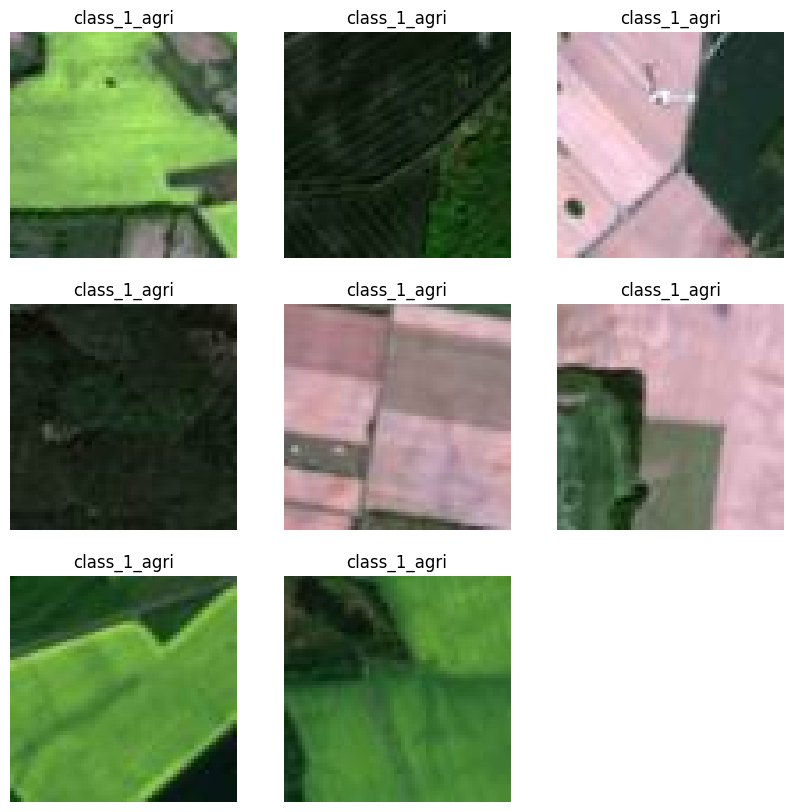

In [11]:
print(f"Class names inferred by Keras: {train_ds.class_names}")

# Visualize one batch from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Take one batch
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3, 3, i + 1)
        # Images are loaded as float32, so we convert to uint8 for display
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

### Configure the dataset for performance

The dedicated utility, `tf.data.Dataset`, can be chained with various methods to create a highly performant pipeline. 
- **`.map(function)`:** Applies a given function to every element of the dataset. Here, it is used to apply data augmentation layers. TensorFlow can automatically parallelize this operation.
- **`.cache()`:** Caches the dataset in memory after it's loaded from disk during the first epoch. For subsequent epochs, data will be read from the faster memory cache, significantly speeding up training. This is **only feasible if** the dataset fits in RAM.
- **`.prefetch(buffer_size)`:** It allows the data preprocessing (done on the CPU) to happen in parallel with the model training (done on the GPU). While the GPU is busy with the current batch, the CPU is already preparing the next batch. This overlapping of tasks prevents the GPU from sitting idle and waiting for data, a phenomenon known as an I/O bottleneck.
- **`AUTOTUNE`** lets TensorFlow dynamically decide the optimal buffer size for your computer.


In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Apply augmentation to the training dataset using map
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Configure for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Dataset is now configured for high performance!")

Dataset is now configured for high performance!


## Comparison and analysis

We've compared two ways to create a data loader in Keras. This comparison highlights the engineering trade-offs between control and convenience.


| Feature                  | Custom data generator                                       | In-built Keras utility (`image_dataset_from_directory`)     |
|--------------------------|-------------------------------------------------------------|-------------------------------------------------------------|
| **Ease of use**          | Low. Requires significant boilerplate code for loops, shuffling, and batching. | High. A single, intuitive function call handles everything. |
| **Code complexity**      | High. You manually manage file paths, labels, loading, and preprocessing. | Low. The function abstracts away all the complexity.          |
| **Flexibility**          | Very high. You can implement any custom logic for loading or non-standard data structures. | Moderate. Designed for a standard directory structure (`class/images`), but very flexible within that. |
| **Features**             | Basic. Shuffling, augmentation, and validation splits must be coded manually. | Rich. Built-in shuffling, batching, and validation splits. Seamless integration with Keras preprocessing layers. |
| **Performance**          | Poor to moderate. A simple Python generator can become an I/O bottleneck for the GPU due to its single-threaded nature. | Excellent. Creates a `tf.data.Dataset` object, which is highly optimized and can be configured with `.cache()` and `.prefetch()` for maximum throughput. |
| **Recommended for**      | Learning purposes or highly specialized, non-standard datasets (e.g., loading from a database or a custom binary format). | **Almost all standard image classification tasks.**         |


---
**Notebook 02 Conclusion:** This module successfully evaluated the transition from custom, single-threaded Pythonic generators to the high-performance **`tf.data` pipeline architecture**. 

While the custom generator served as a baseline for understanding "on-the-fly" ingestion, the native Keras utility was selected for the final research study due to its superior architectural advantages:
* **Asynchronous Execution:** Built-in support for `.prefetch()` and `.cache()` effectively decouples data preprocessing from model execution.
* **Hardware Acceleration:** Native C++ backends minimize the Python Global Interpreter Lock (GIL) overhead.
* **Scalability:** The pipeline is designed to sustain GPU saturation, providing the necessary backbone for the computationally intensive **CNN-ViT Hybrid Integration** in Module 03.